In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage.filters import gaussian_filter as smooth


%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 3

font = {'weight' : 'normal',
      'size'   : 17}

plt.rc('font', **font)

import fair
from fair.fair_inverse_model import co2_conc_total as rf_to_conc
from fair.fair_inverse_model import annual_emissions_calc2 as conc_to_emissions
from fair.forward import fair_scm as FAIR_model
fair.__version__

'1.0.1'

In [3]:
# Using Fair to go RCP3PD emissions -> radiative forcings for CH4 and CO2

#C_0 = 279.51
#F_2x= 3.71
#a = np.array([0.05,0.236489403703,0.3,0.413510596297])
#r0 = 39.1193644809
#rC=0.0152
#rT=3.332

emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0 * 0.73

concs_filem = './fair/GCP_data/RCP3PD_MIDYEAR_CONCENTRATIONS.csv'
concs_datam = np.genfromtxt(concs_filem,skip_header=37,delimiter=',',names=True)
M_concs = concs_datam['CH4']
N_concs = concs_datam['N2O']
concs = concs_datam['CO2']

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']

#total
C,T,RF,M,N,MK_gas,db,tau_M,tau_N = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just CO2
C_co2,T_co2,RF_co2,M_co2,N_co2,MK_gas_co2,db_co2,tau_M_co2,tau_N_co2 = FAIR_model(
                            emissions=emissions,N_0=270.0,MAGICC_model = True,)
                            #S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just CH4
C_ch4,T_ch4,RF_ch4,M_ch4,N_ch4,MK_gas_ch4,db_ch4,tau_M_ch4,tau_N_ch4 = FAIR_model(other_rf = np.zeros(emissions.size),
                            M_emissions=M_emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just N2O
C_n2o,T_n2o,RF_n2o,M_n2o,N_n2o,MK_gas_n2o,db_n2o,tau_M_n2o,tau_N_n2o = FAIR_model(other_rf = np.zeros(emissions.size),
                            N_emissions=N_emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just other
C_other,T_other,RF_other,M_other,N_other,MK_gas_other,db_other,tau_M_other,tau_N_other = FAIR_model(
                            other_rf = other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
    
#anthro total from RCP3 RF datafile    
C_nonono,T_0,RF_0,M_0,N_0,MK_gas_0,db_0,tau_M_0,tau_N_0 = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

ANTHRO_RF_0 = smooth(RF_0,5)
ANTHRO_RF = smooth(RF,5)
CH4_RF = smooth(RF_ch4,5)
N2O_RF = smooth(RF_n2o,5)
CO2_RF = smooth(RF_co2,5)
other_RF = smooth(RF_other,5)

In [4]:
ANTHRO_conc = rf_to_conc(ANTHRO_RF) #, a = F_2x/np.log(2) , Cpreind = C_0)
CH4_conc = rf_to_conc(CH4_RF) #, a = F_2x/np.log(2) , Cpreind = C_0)
CO2_conc = rf_to_conc(CO2_RF) #, a = F_2x/np.log(2) , Cpreind = C_0)
N2O_conc = rf_to_conc(N2O_RF) #, a = F_2x/np.log(2) , Cpreind = C_0)
other_conc = rf_to_conc(other_RF) #, a = F_2x/np.log(2), Cpreind = C_0)

ANTHRO_conc_0 = rf_to_conc(ANTHRO_RF_0) #, a = F_2x/np.log(2) , Cpreind = C_0)

In [5]:
anthro_CO2_fe_emms = conc_to_emissions(ANTHRO_conc,T,year_smoothing=0)* 44./12. #, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
CH4_CO2_fe_emms = conc_to_emissions(CH4_conc,T_ch4,year_smoothing=0)* 44./12. #,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
CO2_CO2_fe_emms = conc_to_emissions(CO2_conc,T_co2,year_smoothing=0)* 44./12. #,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
N2O_CO2_fe_emms = conc_to_emissions(N2O_conc,T_n2o,year_smoothing=0)* 44./12. #,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
other_CO2_fe_emms = conc_to_emissions(other_conc,T_other,year_smoothing=0)* 44./12. #,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

anthro_CO2_fe_emms_0 = conc_to_emissions(ANTHRO_conc_0,T_0,year_smoothing=0)* 44./12. #,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

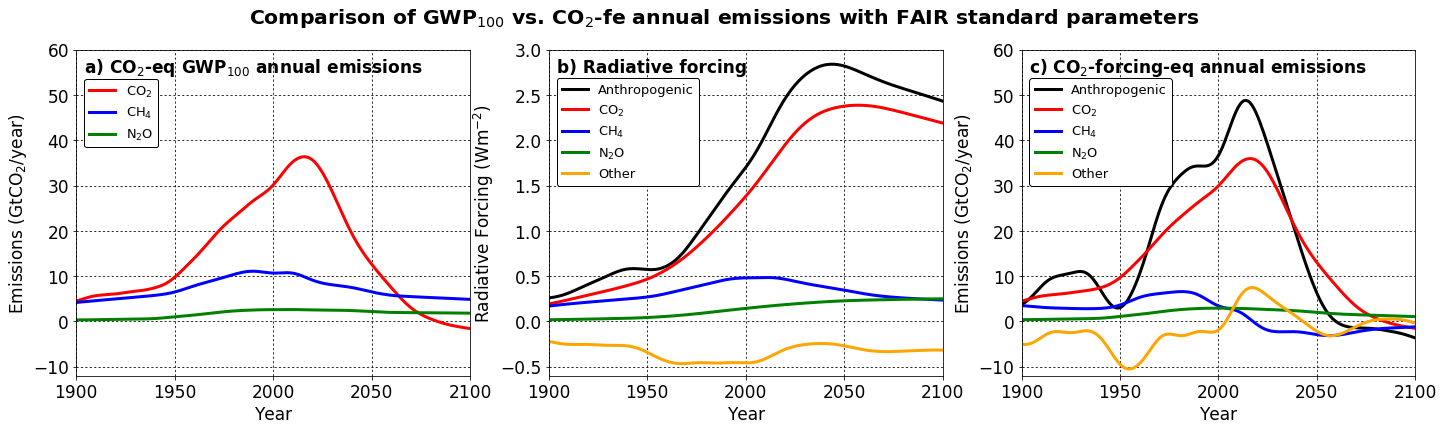

In [6]:
time = np.arange(1765,2501)

CO2_emissions = emissions * 44./12.
CH4_CO2_eq_GWP = M_emissions * 34./1000.
N2O_CO2_eq_GWP = N_emissions * 298./1000.

cum_CO2_fe = np.cumsum(CO2_CO2_fe_emms)
cum_CH4_fe = np.cumsum(CH4_CO2_fe_emms)
cum_N2O_fe = np.cumsum(N2O_CO2_fe_emms)
cum_anthro_fe = np.cumsum(anthro_CO2_fe_emms)
cum_other_fe = np.cumsum(other_CO2_fe_emms)

cum_anthro_fe_0 = np.cumsum(anthro_CO2_fe_emms_0)

# Smoothing

CO2_emissions_smooth = smooth(CO2_emissions,5)
CH4_CO2_eq_GWP_smooth = smooth(CH4_CO2_eq_GWP,5)
N2O_CO2_eq_GWP_smooth = smooth(N2O_CO2_eq_GWP,5)
cum_CO2_emms_GWP = np.cumsum(CO2_emissions_smooth)
cum_CH4_emms_GWP = np.cumsum(CH4_CO2_eq_GWP_smooth)
cum_N2O_emms_GWP = np.cumsum(N2O_CO2_eq_GWP_smooth)

fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(131)
ax3 = fig.add_subplot(133)
ax5 = fig.add_subplot(132)

ax1.grid(linestyle = ':',color = 'black')
ax1.text(1904,55,'a) CO$_2$-eq GWP$_{100}$ annual emissions',fontweight='bold')
ax1.plot(time,CO2_emissions_smooth,label='CO$_2$',color='red')
ax1.plot(time,CH4_CO2_eq_GWP_smooth,label='CH$_4$',color='blue')
ax1.plot(time,N2O_CO2_eq_GWP_smooth,label='N$_2$O',color='green')
ax1.set_ylabel('Emissions (GtCO$_2$/year)')
ax1.set_xlabel('Year')
ax1.legend(loc=(0.02,0.7),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax1.set_xlim(1900,2100)
ax1.set_ylim(-12.,60.)

ax3.grid(linestyle = ':',color = 'black')
ax3.text(1904,55,'c) CO$_2$-forcing-eq annual emissions',fontweight='bold')
ax3.plot(time,anthro_CO2_fe_emms_0,label='Anthropogenic',color='black')
ax3.plot(time,CO2_CO2_fe_emms,label='CO$_2$',color='red')
ax3.plot(time,CH4_CO2_fe_emms,label='CH$_4$',color='blue')
ax3.plot(time,N2O_CO2_fe_emms,label='N$_2$O',color='green')
ax3.plot(time,other_CO2_fe_emms,label='Other',color='orange')
ax3.set_xlabel('Year')
ax3.set_ylabel('Emissions (GtCO$_2$/year)')
ax3.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax3.set_xlim(1900,2100)
ax3.set_ylim(-12.,60.)

ax5.grid(linestyle = ':',color = 'black')
ax5.text(1904,2.75,'b) Radiative forcing',fontweight='bold')
ax5.plot(time,ANTHRO_RF_0,label='Anthropogenic',color='black')
ax5.plot(time,CO2_RF,label='CO$_2$',color='red')
ax5.plot(time,CH4_RF,label='CH$_4$',color='blue')
ax5.plot(time,N2O_RF,label='N$_2$O',color='green')
ax5.plot(time,other_RF,label='Other',color='orange')
ax5.set_xlabel('Year')
ax5.set_ylabel('Radiative Forcing (Wm$^{-2}$)')
ax5.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax5.set_xlim(1900,2100)
ax5.set_ylim(-0.6,3.0)

fig.suptitle('Comparison of GWP$_{100}$ vs. CO$_2$-fe annual emissions with FAIR standard parameters', fontweight = 'bold')

#fig.savefig('./Figures-final/CO2-e vs CO2-fe Figure_FAIR_standard_params_adding.png',dpi=600)

In [7]:
#CHECKING THE RADIATIVE FORCING DATA, IE COMPARING CO2 ADDING AND DIFFERENCING (MAGICC PARAMS),
#CO2 ADDING FAIR STANDARD VS MAGICC PARAMS,
#METHANE ADDING FAIR STANDARD VS MAGICC PARAMS, (HIGHLIGHTS HOW METHANE IS UNCHANGED BY PARAM CHOICE 
    #BECAUSE PARAMS HERE ARE SET BY NICK AND FIXED)

C_0 = 279.51
F_2x= 3.71
C_0=C_0
a = np.array([0.05,0.236489403703,0.3,0.413510596297])
r0 = 39.1193644809
rC=0.0152
rT=3.332

#total anthro from RF RCP3PD data, MAGICC params
C_0_1,T_0_1,RF_0_1,M_0_1,N_0_1,MK_gas_0_1,db_0_1,tau_M_0_1,tau_N_0_1 = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#total anthro calculated with fair forward, MAGICC params
C_2,T_2,RF_2,M_2,N_2,MK_gas_2,db_2,tau_M_2,tau_N_2 = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#CO2 adding, MAGICC params
C_CO2_1,T_CO2_1,RF_CO2_1,M_CO2_1,N_CO2_1,MK_gas_CO2_1,db_CO2_1,tau_M_CO2_1,tau_N_CO2_1 = FAIR_model(
                            emissions = emissions,
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#MH4 adding, MAGICC params
C_ch4_1,T_ch4_1,RF_ch4_1,M_ch4_1,N_ch4_1,MK_gas_ch4_1,db_ch4_1,tau_M_ch4_1,tau_N_ch4_1 = FAIR_model(other_rf = np.zeros(emissions.size),
                            M_emissions=M_emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#N2O adding, MAGICC params
C_n2o_1,T_n2o_1,RF_n2o_1,M_n2o_1,N_n2o_1,MK_gas_n2o_1,db_n2o_1,tau_M_n2o_1,tau_N_n2o_1 = FAIR_model(other_rf = np.zeros(emissions.size),
                            N_emissions=N_emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#other adding, MAGICC params
C_other_1,T_other_1,RF_other_1,M_other_1,N_other_1,MK_gas_other_1,db_other_1,tau_M_other_1,tau_N_other_1 = FAIR_model(
                            other_rf = other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#smoothing RFs (magicc)
ANTHRO_0_magicc = smooth(RF_0_1,5)
ANTHRO_2 = smooth(RF_2,5)
RF_CO2_1 = smooth(RF_CO2_1,5)
RF_ch4_1 = smooth(RF_ch4_1,5)
RF_n2o_1 = smooth(RF_n2o_1,5)
RF_other_1 = smooth(RF_other_1,5)

#calcualting concs (magicc)
ANTHRO_magicc_conc = rf_to_conc(ANTHRO_2, a = F_2x/np.log(2) , Cpreind = C_0)
CH4_magicc_conc = rf_to_conc(RF_ch4_1, a = F_2x/np.log(2) , Cpreind = C_0)
CO2_magicc_conc = rf_to_conc(RF_CO2_1, a = F_2x/np.log(2) , Cpreind = C_0)
N2O_magicc_conc = rf_to_conc(RF_n2o_1, a = F_2x/np.log(2) , Cpreind = C_0)
other_magicc_conc = rf_to_conc(RF_other_1, a = F_2x/np.log(2), Cpreind = C_0)

ANTHRO_0_magicc_conc = rf_to_conc(ANTHRO_0_magicc, a = F_2x/np.log(2) , Cpreind = C_0)

#calculating emissions (magicc)
anthro_CO2_fe_emms_magicc = conc_to_emissions(ANTHRO_magicc_conc,T_2,year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
CH4_CO2_fe_emms_magicc = conc_to_emissions(CH4_magicc_conc,T_ch4_1,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
CO2_CO2_fe_emms_magicc = conc_to_emissions(CO2_magicc_conc,T_CO2_1,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
N2O_CO2_fe_emms_magicc = conc_to_emissions(N2O_magicc_conc,T_n2o_1,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
other_CO2_fe_emms_magicc = conc_to_emissions(other_magicc_conc,T_other_1,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

anthro_CO2_fe_emms_0_magicc = conc_to_emissions(ANTHRO_0_magicc_conc,T_0_1,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

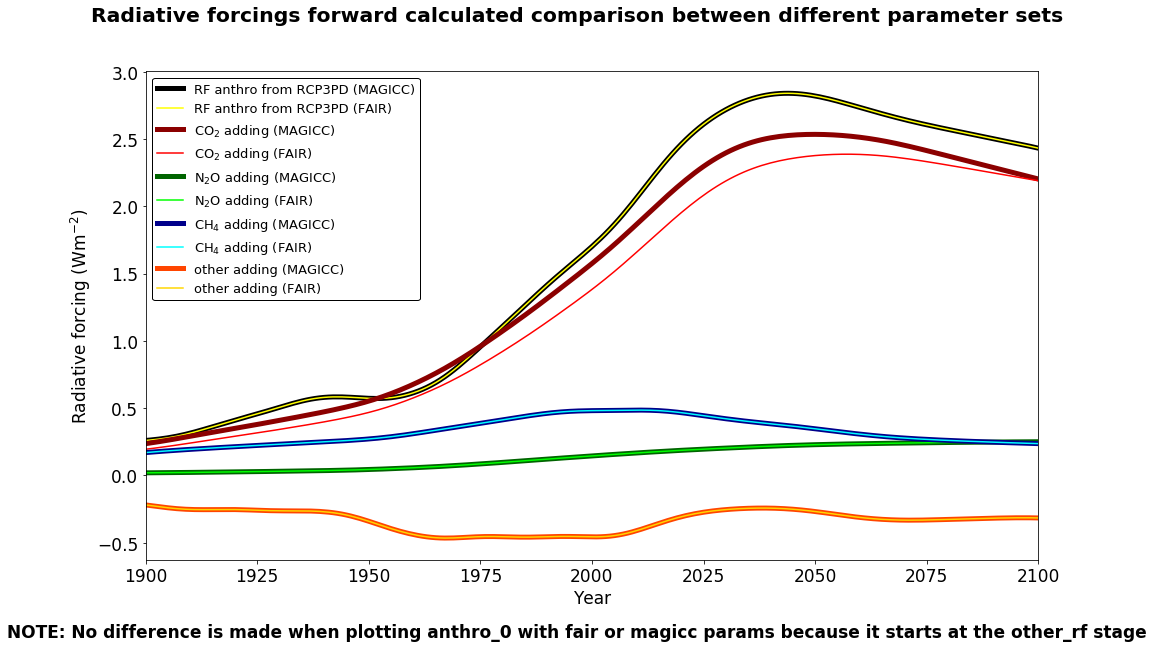

In [8]:
#plotting RFs calculated with different parameters

fig3 = plt.figure()
ax22 = fig3.add_subplot(111)

ax22.plot(time, ANTHRO_0_magicc, color = 'black', label = 'RF anthro from RCP3PD (MAGICC)', linewidth = 5)
ax22.plot(time, ANTHRO_RF_0, color = 'yellow', label = 'RF anthro from RCP3PD (FAIR)', linewidth = 1.5)
ax22.plot(time, RF_CO2_1, color = 'darkred', label = 'CO$_2$ adding (MAGICC)', linewidth = 5)
ax22.plot(time, CO2_RF, color = 'red', label = 'CO$_2$ adding (FAIR)', linewidth = 1.5)
ax22.plot(time, RF_n2o_1, color = 'darkgreen', label = 'N$_2$O adding (MAGICC)', linewidth = 5)
ax22.plot(time, N2O_RF, color = 'lime', label = 'N$_2$O adding (FAIR)', linewidth = 1.5)
ax22.plot(time, RF_ch4_1, color = 'darkblue', label = 'CH$_4$ adding (MAGICC)', linewidth = 5)
ax22.plot(time, CH4_RF, color = 'cyan', label = 'CH$_4$ adding (FAIR)', linewidth = 1.5)
ax22.plot(time, RF_other_1, color = 'orangered', label = 'other adding (MAGICC)', linewidth = 5)
ax22.plot(time, other_RF, color = 'gold', label = 'other adding (FAIR)', linewidth = 1.5)
ax22.grid(True, ':')
ax22.set_xlabel('Year')
ax22.set_ylabel('Radiative forcing (Wm$^{-2}$)')
ax22.legend(loc = 'upper left', framealpha = 1, shadow = False, edgecolor = 'black', fontsize=13)
ax22.set_xlim(1900,2100)
ax22.text(1869,-1.2,'NOTE: No difference is made when plotting anthro_0 with fair or magicc params because it starts at the other_rf stage',fontweight = 'bold')
fig3.suptitle('Radiative forcings forward calculated comparison between different parameter sets', fontweight = 'bold')

#fig3.savefig('./Figures-final/Radiative forcings comparison between different parameter sets.png',dpi=600)

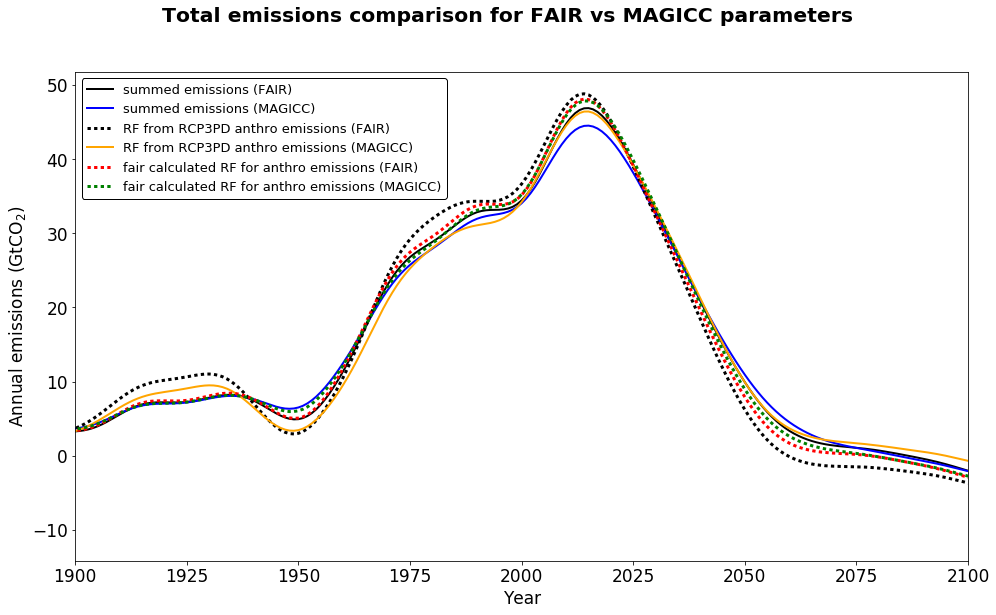

In [9]:
#COMPARES THE DIFFERENT TOTAL EMISIONS, WITH DIFFERENT PARAMETERS

total_emms = CO2_CO2_fe_emms + CH4_CO2_fe_emms + N2O_CO2_fe_emms + other_CO2_fe_emms

total_emms_magicc = CO2_CO2_fe_emms_magicc + CH4_CO2_fe_emms_magicc + N2O_CO2_fe_emms_magicc + other_CO2_fe_emms_magicc

fig2 = plt.figure()
ax11 = fig2.add_subplot(111)

ax11.plot(time, total_emms, color = 'black', label = 'summed emissions (FAIR)', linewidth = 2)
ax11.plot(time, total_emms_magicc, color = 'blue', label = 'summed emissions (MAGICC)', linewidth = 2)
ax11.plot(time, anthro_CO2_fe_emms_0, ':', color = 'black', label = 'RF from RCP3PD anthro emissions (FAIR)')
ax11.plot(time, anthro_CO2_fe_emms_0_magicc, color = 'orange', label = 'RF from RCP3PD anthro emissions (MAGICC)', linewidth = 2)
ax11.plot(time, anthro_CO2_fe_emms, ':', color = 'red', label = 'fair calculated RF for anthro emissions (FAIR)')
ax11.plot(time, anthro_CO2_fe_emms_magicc, ':', color = 'green', label = 'fair calculated RF for anthro emissions (MAGICC)')
ax11.grid(True, ':') 
ax11.set_xlim(1900,2100)
ax11.set_xlabel('Year')
ax11.set_ylabel('Annual emissions (GtCO$_2$)')
ax11.legend(loc = 'upper left', framealpha = 1, shadow = False, edgecolor = 'black', fontsize=13)
fig2.suptitle('Total emissions comparison for FAIR vs MAGICC parameters', fontweight = 'bold')

#fig2.savefig('./Figures-final/Total emissions comparison for FAIR vs MAGICC parameters.png',dpi=600)

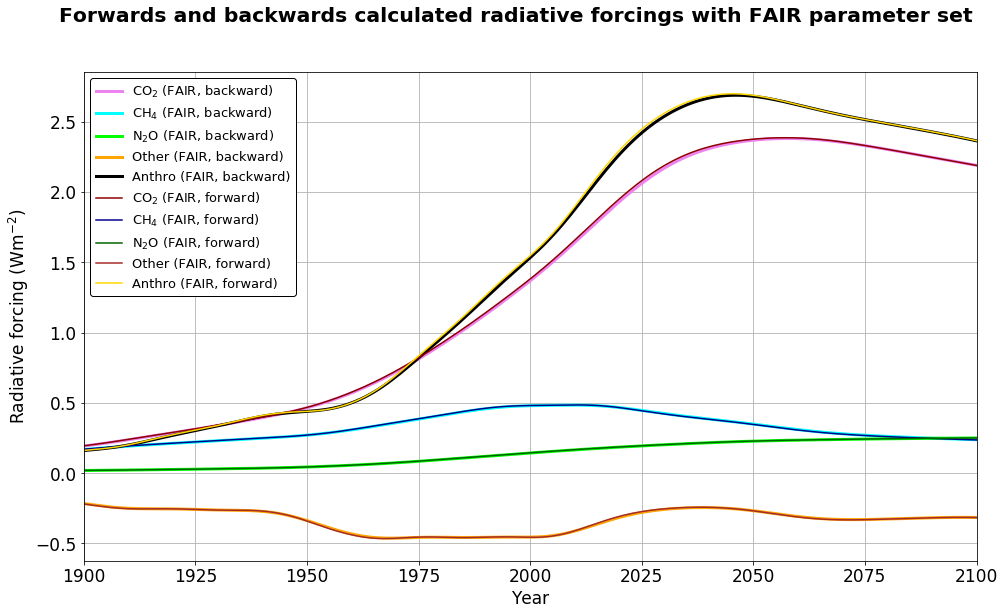

In [10]:
#compares the radiative forcings backwards and forwards calculated

# co2_RF backwards calculated, FAIR params
C_co2_backward,T_co2_backward,RF_co2_backward,M_co2_backward,N_co2_backward,MK_gas_co2_backward,db_co2_backward,tau_M_co2_backward,tau_N_co2_backward = FAIR_model(
                            emissions = CO2_CO2_fe_emms*12./44., MAGICC_model = True)

# ch4_RF backwards calculated, FAIR params
C_ch4_backward,T_ch4_backward,RF_ch4_backward,M_ch4_backward,N_ch4_backward,MK_gas_ch4_backward,db_ch4_backward,tau_M_ch4_backward,tau_N_ch4_backward = FAIR_model(
                            emissions = CH4_CO2_fe_emms*12./44., MAGICC_model = True)

# n2o_RF backwards calculated, FAIR params
C_n2o_backward,T_n2o_backward,RF_n2o_backward,M_n2o_backward,N_n2o_backward,MK_gas_n2o_backward,db_n2o_backward,tau_M_n2o_backward,tau_N_n2o_backward = FAIR_model(
                            emissions = N2O_CO2_fe_emms*12./44., MAGICC_model = True)

# other_RF backwards calculated, FAIR params
C_other_backward,T_other_backward,RF_other_backward,M_other_backward,N_other_backward,MK_gas_other_backward,db_other_backward,tau_M_other_backward,tau_N_other_backward = FAIR_model(
                            emissions = other_CO2_fe_emms*12./44., MAGICC_model = True)

# anthro_RF backwards calculated, FAIR params
C_anthro_backward,T_anthro_backward,RF_anthro_backward,M_anthro_backward,N_anthro_backward,MK_gas_anthro_backward,db_anthro_backward,tau_M_anthro_backward,tau_N_anthro_backward = FAIR_model(
                            emissions = anthro_CO2_fe_emms*12./44., MAGICC_model = True)


fig4 = plt.figure()
ax33 = fig4.add_subplot(111)

ax33.plot(time, RF_co2_backward, color = 'violet', label = 'CO$_2$ (FAIR, backward)')
ax33.plot(time, RF_ch4_backward, color = 'cyan', label = 'CH$_4$ (FAIR, backward)')
ax33.plot(time, RF_n2o_backward, color = 'lime', label = 'N$_2$O (FAIR, backward)')
ax33.plot(time, RF_other_backward, color = 'orange', label = 'Other (FAIR, backward)')
ax33.plot(time, RF_anthro_backward, color = 'black', label = 'Anthro (FAIR, backward)')
ax33.plot(time, CO2_RF, color = 'darkred', linewidth = 1.5, label = 'CO$_2$ (FAIR, forward)')
ax33.plot(time, CH4_RF, color = 'darkblue', linewidth = 1.5, label = 'CH$_4$ (FAIR, forward)')
ax33.plot(time, N2O_RF, color = 'darkgreen', linewidth = 1.5, label = 'N$_2$O (FAIR, forward)')
ax33.plot(time, other_RF, color = 'brown', linewidth = 1.5, label = 'Other (FAIR, forward)')
ax33.plot(time, ANTHRO_RF, color = 'gold', linewidth = 1.5, label = 'Anthro (FAIR, forward)')
ax33.set_xlim(1900,2100)
ax33.set_xlabel('Year')
ax33.set_ylabel('Radiative forcing (Wm$^{-2}$)')
ax33.grid(True)
ax33.legend(loc = 'upper left', framealpha = 1, shadow = False, edgecolor = 'black', fontsize=13)

fig4.suptitle('Forwards and backwards calculated radiative forcings with FAIR parameter set', fontweight = 'bold')

#fig4.savefig('./Figures-final/Forwards and backwards calculated radiative forcings with FAIR parameter set.png',dpi=600)

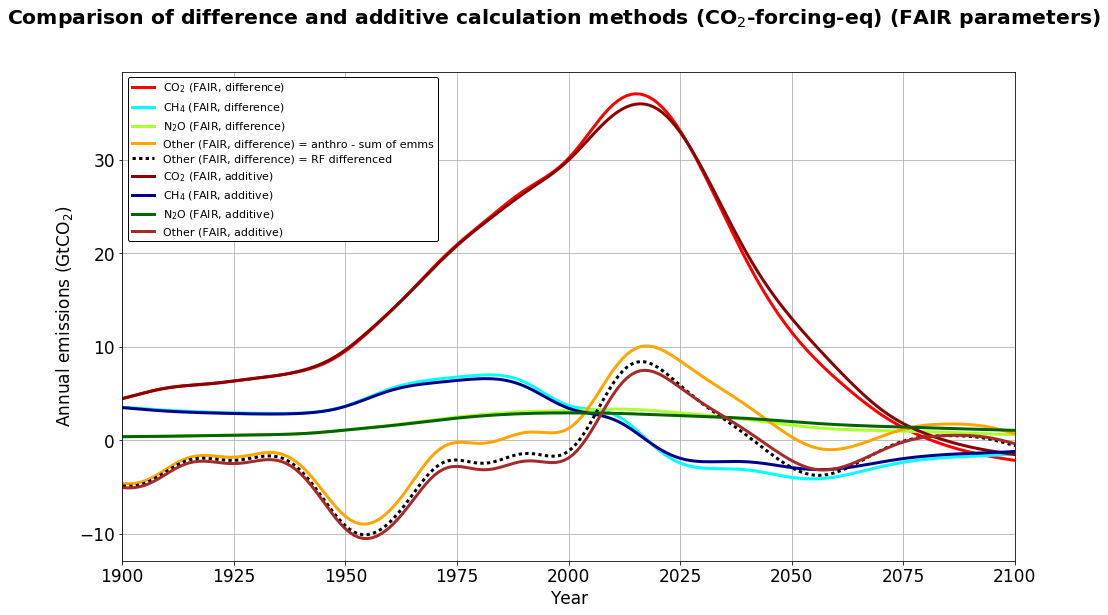

In [11]:
#creating plot to compare the additive and differencing methods

#differencing calculations, FAIR parameters
C_minus_CH4,T_minus_CH4,RF_minus_CH4,M_minus_CH4,N_minus_CH4,MK_gas_minus_CH4,db_minus_CH4,tau_M_minus_CH4,tau_N_minus_CH4 = FAIR_model(
                            emissions=emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

C_minus_N2O,T_minus_N2O,RF_minus_N2O,M_minus_N2O,N_minus_N2O,MK_gas_minus_N2O,db_minus_N2O,tau_M_minus_N2O,tau_N_minus_N2O = FAIR_model(
                            emissions=emissions,M_emissions=M_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

C_minus_CO2,T_minus_CO2,RF_minus_CO2,M_minus_CO2,N_minus_CO2,MK_gas_minus_CO2,db_minus_CO2,tau_M_minus_CO2,tau_N_minus_CO2 = FAIR_model(
                            emissions = np.zeros(len(other_rf)), M_emissions=M_emissions,N_emissions=N_emissions, other_rf=other_rf,
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#smoothing
RF_minus_CH4 = smooth(RF_minus_CH4,5)
RF_minus_N2O = smooth(RF_minus_N2O,5)
RF_minus_CO2 = smooth(RF_minus_CO2,5)

#calculating other by taking other RF through from top...
RF_minus_other = ANTHRO_RF - other_RF
C_minus_other,T_minus_other,RF_minus_other_2,M_minus_other,N_minus_other,MK_gas_minus_other,db_minus_other,tau_M_minus_other,tau_N_minus_other = FAIR_model(
                            other_rf=RF_minus_other,N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,)
                            #F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#calculating concentrations
ANTHRO_minus_CH4_conc = rf_to_conc(RF_minus_CH4) #, a = F_2x/np.log(2) , Cpreind = C_0)
ANTHRO_minus_CO2_conc = rf_to_conc(RF_minus_CO2) #, a = F_2x/np.log(2) , Cpreind = C_0)
ANTHRO_minus_N2O_conc = rf_to_conc(RF_minus_N2O) #, a = F_2x/np.log(2) , Cpreind = C_0)

ANTHRO_minus_other_conc = rf_to_conc(RF_minus_other) #, a = F_2x/np.log(2) , Cpreind = C_0)

#calculating emissions
ANTHRO_minus_CH4_emms = conc_to_emissions(ANTHRO_minus_CH4_conc,T_minus_CH4,year_smoothing=0)* 44./12. #,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
ANTHRO_minus_CO2_emms = conc_to_emissions(ANTHRO_minus_CO2_conc,T_minus_CO2,year_smoothing=0)* 44./12. #,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
ANTHRO_minus_N2O_emms = conc_to_emissions(ANTHRO_minus_N2O_conc,T_minus_N2O,year_smoothing=0)* 44./12. #,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

ANTHRO_minus_other_emms = conc_to_emissions(ANTHRO_minus_other_conc,T_minus_other,year_smoothing=0)* 44./12.

CO2_emms_diff = anthro_CO2_fe_emms - ANTHRO_minus_CO2_emms
CH4_emms_diff = anthro_CO2_fe_emms - ANTHRO_minus_CH4_emms
N2O_emms_diff = anthro_CO2_fe_emms - ANTHRO_minus_N2O_emms
other_emms_diff = anthro_CO2_fe_emms - CH4_emms_diff - CO2_emms_diff

other_emms_calc = anthro_CO2_fe_emms - ANTHRO_minus_other_emms




#PLOTTING

fig5 = plt.figure()
ax44 = fig5.add_subplot(111)

ax44.plot(time, CO2_emms_diff, color = 'red', label = 'CO$_2$ (FAIR, difference)')
ax44.plot(time, CH4_emms_diff, color = 'cyan', label = 'CH$_4$ (FAIR, difference)')
ax44.plot(time, N2O_emms_diff, color = 'greenyellow', label = 'N$_2$O (FAIR, difference)')
ax44.plot(time, other_emms_diff, color = 'orange', label = 'Other (FAIR, difference) = anthro - sum of emms')

ax44.plot(time, other_emms_calc, ':', color = 'black', label = 'Other (FAIR, difference) = RF differenced')

ax44.plot(time, CO2_CO2_fe_emms, color = 'darkred', label = 'CO$_2$ (FAIR, additive)')
ax44.plot(time, CH4_CO2_fe_emms, color = 'darkblue', label = 'CH$_4$ (FAIR, additive)')
ax44.plot(time, N2O_CO2_fe_emms, color = 'darkgreen', label = 'N$_2$O (FAIR, additive)')
ax44.plot(time, other_CO2_fe_emms, color = 'brown', label = 'Other (FAIR, additive)')
ax44.set_xlim(1900,2100)
ax44.set_xlabel('Year')
ax44.set_ylabel('Annual emissions (GtCO$_2$)')
ax44.grid(True)
ax44.legend(loc = 'upper left', framealpha = 1, shadow = False, edgecolor = 'black', fontsize=11)

fig5.suptitle('Comparison of difference and additive calculation methods (CO$_2$-forcing-eq) (FAIR parameters)', fontweight = 'bold')

#fig5.savefig('./Figures-final/Comparison of difference and additive calculation methods.png',dpi=600)

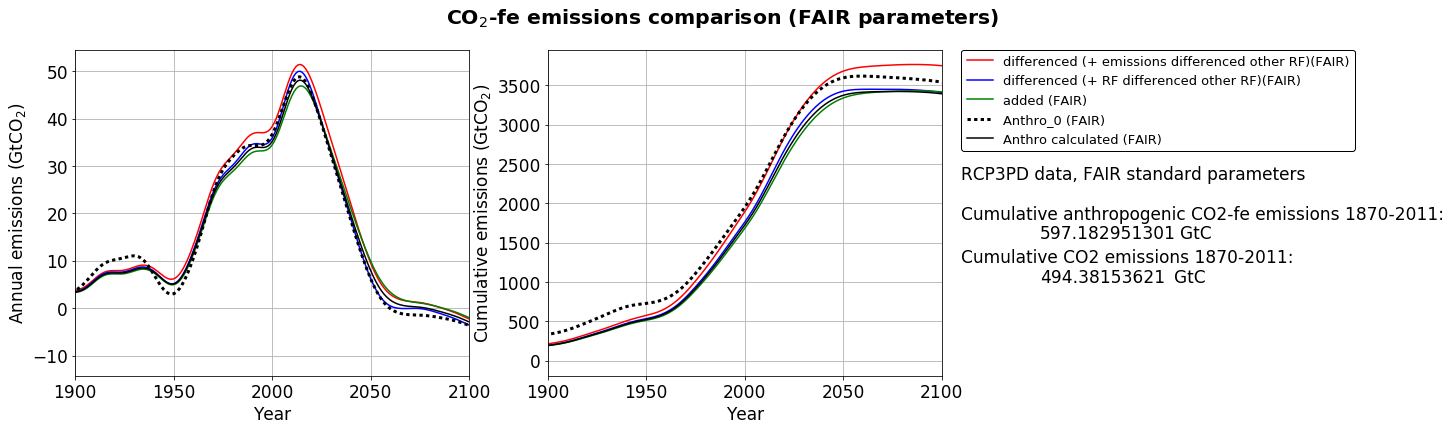

In [12]:
#comparing adding vs differencing (FAIR params) for total emissions

total_1 = CO2_emms_diff + CH4_emms_diff + N2O_emms_diff + other_emms_diff
total_2 = CO2_emms_diff + CH4_emms_diff + N2O_emms_diff + other_emms_calc
total_3 = CO2_CO2_fe_emms + CH4_CO2_fe_emms + N2O_CO2_fe_emms + other_CO2_fe_emms

fig6 = plt.figure(figsize=(24,6))
ax55 = fig6.add_subplot(131)
ax66 = fig6.add_subplot(132)
ax55.plot(time, total_1, linewidth = 1.5, color = 'red', label = 'differenced (+ emissions differenced other RF)(FAIR)')
ax55.plot(time, total_2, linewidth = 1.5, color = 'blue', label = 'differenced (+ RF differenced other RF)(FAIR)')
ax55.plot(time, total_3, linewidth = 1.5, color = 'green', label = 'added (FAIR)')
ax55.plot(time, anthro_CO2_fe_emms_0, ':', color = 'black', label = 'Anthro_0 (FAIR)')
ax55.plot(time, anthro_CO2_fe_emms, linewidth = 1.5, color = 'black', label = 'Anthro calculated (FAIR)')
ax55.set_xlim(1900,2100)
ax55.set_xlabel('Year')
ax55.set_ylabel('Annual emissions (GtCO$_2$)')
ax55.grid(True)
#ax55.legend(loc = 'upper left', framealpha = 1, shadow = False, edgecolor = 'black', fontsize=13)

ax66.plot(time, np.cumsum(total_1), linewidth = 1.5, color = 'red', label = 'differenced (+ emissions differenced other RF)(FAIR)')
ax66.plot(time, np.cumsum(total_2), linewidth = 1.5, color = 'blue', label = 'differenced (+ RF differenced other RF)(FAIR)')
ax66.plot(time, np.cumsum(total_3), linewidth = 1.5, color = 'green', label = 'added (FAIR)')
ax66.plot(time, cum_anthro_fe_0, ':', color = 'black', label = 'Anthro_0 (FAIR)')
ax66.plot(time, cum_anthro_fe, linewidth = 1.5, color = 'black', label = 'Anthro calculated (FAIR)')
ax66.set_xlim(1900,2100)
ax66.set_xlabel('Year')
ax66.set_ylabel('Cumulative emissions (GtCO$_2$)')
ax66.grid(True)
ax66.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., framealpha = 1, shadow = False, edgecolor = 'black', fontsize=13)
fig6.suptitle('CO$_2$-fe emissions comparison (FAIR parameters)', fontweight = 'bold')

ax66.text(2110,2300, 'RCP3PD data, FAIR standard parameters') 
ax66.text(2110,1800,'Cumulative anthropogenic CO2-fe emissions 1870-2011:')
ax66.text(2150,1550, str((cum_anthro_fe_0[2011-1765] - cum_anthro_fe_0[1870-1765])* 12./44.)) 
ax66.text(2221,1550, 'GtC') 
ax66.text(2110,1250,'Cumulative CO2 emissions 1870-2011:')
ax66.text(2150,1000, str((cum_CO2_fe[2011-1765] - cum_CO2_fe[1870-1765])* 12./44.)) 
ax66.text(2218,1000, 'GtC') 

#fig6.savefig('./Figures-final/Differenced and added emissions (FAIR).png',dpi=600)

NOTE: MUST ADD LINES FOR MAGICC PARAMS TO SEE IF IT IMPROVES ESTIMATES


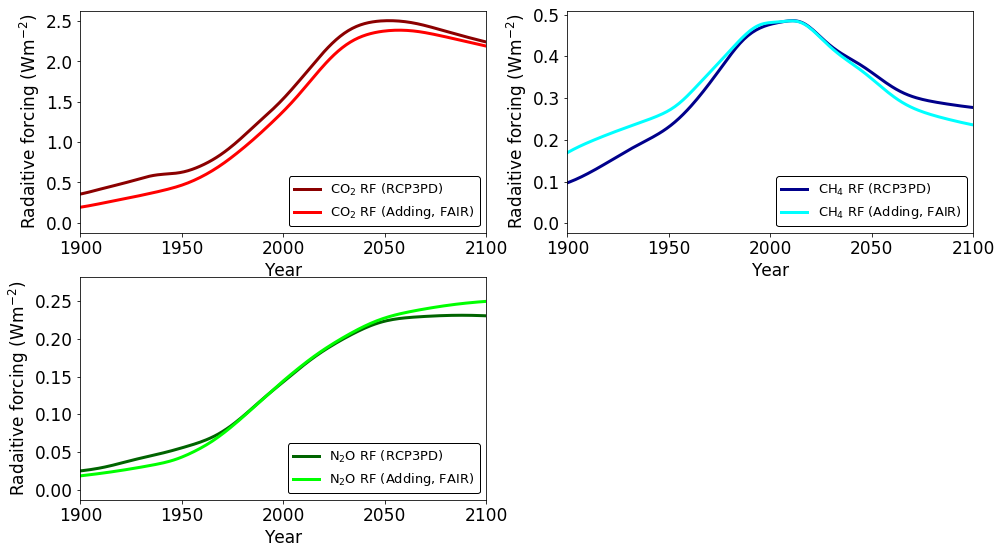

In [16]:
# Creating figure comparing RCP3PD RF data to our results

fig7 = plt.figure(figsize=(16,9))

ax77 = fig7.add_subplot(221)
ax77.plot(time, smooth(forc_data['CO2_RF'],5), color = 'darkred', label = 'CO$_2$ RF (RCP3PD)')
ax77.plot(time, CO2_RF, color = 'red', label = 'CO$_2$ RF (Adding, FAIR)')
ax77.set_xlim(1900,2100)
ax77.set_xlabel('Year')
ax77.set_ylabel('Radaitive forcing (Wm$^{-2}$)')
ax77.legend(loc = 'lower right', framealpha = 1, shadow = False, edgecolor = 'black', fontsize=13)

ax71 = fig7.add_subplot(222)
ax71.plot(time, smooth(forc_data['CH4_RF'],5), color = 'darkblue', label = 'CH$_4$ RF (RCP3PD)')
ax71.plot(time, CH4_RF, color = 'cyan', label = 'CH$_4$ RF (Adding, FAIR)')
ax71.set_xlim(1900,2100)
ax71.set_xlabel('Year')
ax71.set_ylabel('Radaitive forcing (Wm$^{-2}$)')
ax71.legend(loc = 'lower right', framealpha = 1, shadow = False, edgecolor = 'black', fontsize=13)

ax72 = fig7.add_subplot(223)
ax72.plot(time, smooth(forc_data['N2O_RF'],5), color = 'darkgreen', label = 'N$_2$O RF (RCP3PD)')
ax72.plot(time, N2O_RF, color = 'lime', label = 'N$_2$O RF (Adding, FAIR)')
ax72.set_xlim(1900,2100)
ax72.set_xlabel('Year')
ax72.set_ylabel('Radaitive forcing (Wm$^{-2}$)')
ax72.legend(loc = 'lower right', framealpha = 1, shadow = False, edgecolor = 'black', fontsize=13)

print 'NOTE: MUST ADD LINES FOR MAGICC PARAMS TO SEE IF IT IMPROVES ESTIMATES'